Compare output from dask streaming analysis to results from Fluctana.

We calculate results from RMCs examples/nersc/check_correlation.py for Channels L1102 and L0906 to
results from the streaming analysis package.


In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import adios2
from scipy.signal import stft, spectrogram, detrend

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import sys
sys.path.append("/global/homes/r/rkube/repos/delta")
from analysis.channels import channel

In [97]:
win = np.hanning(512)
win_factor = np.mean(win**2) 
print("win_Factor = ", win_factor)

win_Factor =  0.374267578125


In [3]:
# Run the fluctana code from RMCs examples/nersc/check_correlation.py

Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L1102, ref = 100%, siglevel = -0.0003 V
Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L0906, ref = 100%, siglevel = -0.0001 V
***fftbins: win_factor = 0.374268
dnum 0 fftbins 37 with hann size 512 overlap 0.5 detrend 0 full 1
***fftbins: win_factor = 0.374268
dnum 1 fftbins 37 with hann size 512 overlap 0.5 detrend 0 full 1


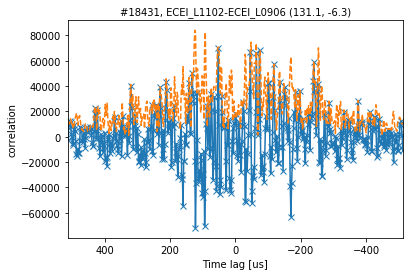

In [4]:
def test_rmc():
    import sys
    sys.path.append("/global/homes/r/rkube/repos/fluctana_rmc")
    from fluctana import FluctAna, KstarEcei

    shot = 18431
    trange = [-0.10, -0.08]
    clist = [['ECEI_L1102'], ['ECEI_L0906']]

    # call fluctana
    A = FluctAna()

    # add data
    A.add_data(KstarEcei(shot=shot, clist=clist[0], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)
    A.add_data(KstarEcei(shot=shot, clist=clist[1], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)

    # do fft; full = 1 
    A.fftbins(nfft=512, window='hann', overlap=0.5, detrend=0, full=1)

    # calculate correlation using data sets done and dtwo. results are saved in A.Dlist[dtwo].val
    A.correlation(done=0, dtwo=1)

    # plot the results; dnum = data set number, cnl = channel number list to plot
    A.mplot(dnum=1,cnl=range(len(A.Dlist[1].clist)),type='val')
    
    return(A)
A = test_rmc()

In [5]:
def fftbins(x, dt, nfft, window, overlap, do_detrend, full):
    # IN : 1 x tnum data
    # OUT : bins x faxis fftdata
    tnum = len(x)
    
    bins = int(np.fix((int(tnum/nfft) - overlap)/(1.0 - overlap)))
    win = np.hanning(nfft)
    #bins, win = fft_window(tnum, nfft, window, overlap)
    win_factor = np.mean(win**2)  # window factors
    print("***fftbins: win_factor = {0:f}".format(win_factor))

    # make an x-axis #
    ax = np.fft.fftfreq(nfft, d=dt) # full 0~fN -fN~-f1
    if np.mod(nfft, 2) == 0:  # even nfft
        ax = np.hstack([ax[0:int(nfft/2)], -(ax[int(nfft/2)]), ax[int(nfft/2):nfft]])
    if full == 1: # full shift to -fN ~ 0 ~ fN
        ax = np.fft.fftshift(ax)
    else: # half 0~fN
        ax = ax[0:int(nfft/2+1)]

    # make fftdata
    if full == 1: # full shift to -fN ~ 0 ~ fN
        if np.mod(nfft, 2) == 0:  # even nfft
            fftdata = np.zeros((bins, nfft+1), dtype=np.complex_)
        else:  # odd nfft
            fftdata = np.zeros((bins, nfft), dtype=np.complex_)
    else: # half 0 ~ fN
        fftdata = np.zeros((bins, int(nfft/2+1)), dtype=np.complex_)

    for b in range(bins):
        idx1 = int(b*np.fix(nfft*(1 - overlap)))
        idx2 = idx1 + nfft
        #print("***bin {0:d}, idx1 = {1:d}, idx2 = {2:d}".format(b, idx1, idx2))

        sx = x[idx1:idx2]

        if do_detrend == 1:
            sx = detrend(sx, type='linear')
        sx = detrend(sx, type='constant')  # subtract mean
        sx = sx * win  # apply window function

        # get fft
        SX = np.fft.fft(sx, n=nfft)/nfft  # divide by the length
        if np.mod(nfft, 2) == 0:  # even nfft
            SX = np.hstack([SX[0:int(nfft/2)], np.conj(SX[int(nfft/2)]), SX[int(nfft/2):nfft]])
        if full == 1: # shift to -fN ~ 0 ~ fN
            SX = np.fft.fftshift(SX)
        else: # half 0 ~ fN
            SX = SX[0:int(nfft/2+1)]

        fftdata[b,:] = SX

    return ax, fftdata, win_factor

***fftbins: win_factor = 0.374268
(37, 513)
***fftbins: win_factor = 0.374268


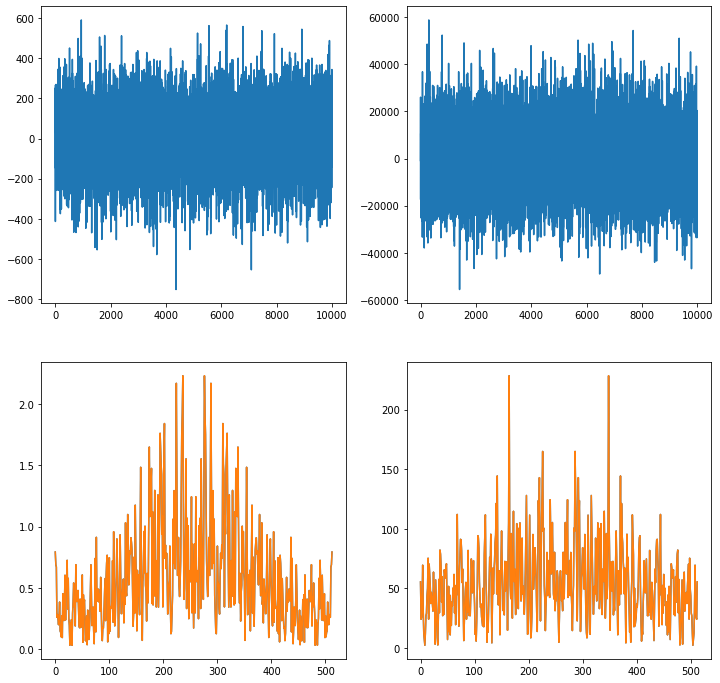

In [253]:
L1102_fa = np.squeeze(A.Dlist[0].data)
L1102_ax, L1102_ft, win_factor = fftbins(L1102_fa, dt=2e-6, nfft=512, window="hann", overlap=0.5, do_detrend=0, full=1)

print(L1102_ft.shape)

L0906_fa = np.squeeze(A.Dlist[1].data)
L0906ax, L0906_ft, win_factor = fftbins(L0906_fa, dt=2e-6, nfft=512, window="hann", overlap=0.5, do_detrend=0, full=1)

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(L1102_fa)
plt.subplot(222)
plt.plot(L0906_fa)

plt.subplot(223)
plt.plot(np.abs(L1102_ft.mean(axis=0)))
plt.plot(np.abs(A.Dlist[0].spdata[0].mean(axis=0)))
plt.subplot(224)
plt.plot(np.abs(L0906_ft.mean(axis=0)))
plt.plot(np.abs(A.Dlist[1].spdata[0].mean(axis=0)))

In [447]:
c1 = channel('L', 11, 2)
c2 = channel('L', 9, 6)

print("Channel 1: ", c1, ", idx = ", c1.idx())
print("Channel 2: ", c2, ", idx = ", c2.idx())

with np.load("../ralphs_task_001.npz") as df:
    res_dask = df["res"]
    
with np.load("../io_array_s0001.npz") as df:
    io_array = df["io_array"]
    print("io_array.shape = ", io_array.shape)

with np.load("../io_array_tr_s0001.npz") as df:
    io_array_tr = df["io_array"]
    print("io_array_tr.shape = ", io_array_tr.shape)

with np.load("../offset_lvl.npz") as df:
    offset_lvl = df["offset_lvl"]
    
with np.load("../fft_data_s0001.npz") as df:
    fft_data = df["fft_data"]
    print("fft_data.shape = ", fft_data.shape)
    
with np.load("../ralphs_task_001.npz") as df:
    ralphs_task = df["res"]
    
_tmp = detrend(io_array, axis=1, type="constant")
res = stft(_tmp, fs=1./2e-6, nperseg=512, window="hann",
                 detrend="constant", noverlap=256, padded=False,
                 return_onesided=False, boundary=None)
io_array_ft = np.fft.fftshift(res[2], axes=1)

fft_data = np.fft.fftshift(fft_data, axes=1)

print("io_array_ft.shape = ", io_array_ft.shape)
print("Channel idx for ", c1, ": {0:d}".format(c1.idx()), " for ", c1, ", {0:d}".format(c2.idx()))

Channel 1:  L1102 , idx =  81
Channel 2:  L0906 , idx =  69
io_array.shape =  (192, 10000)
io_array_tr.shape =  (192, 10000)
fft_data.shape =  (192, 512, 38)
io_array_ft.shape =  (192, 512, 38)
Channel idx for  L1102 : 81  for  L1102 , 69


/global/homes/r/rkube/.conda/envs/xgc-adios2-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


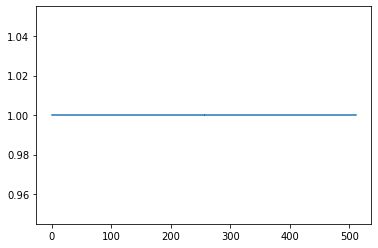

In [20]:
plt.plot(ax[:-1] / np.fft.fftshift(res[0]))

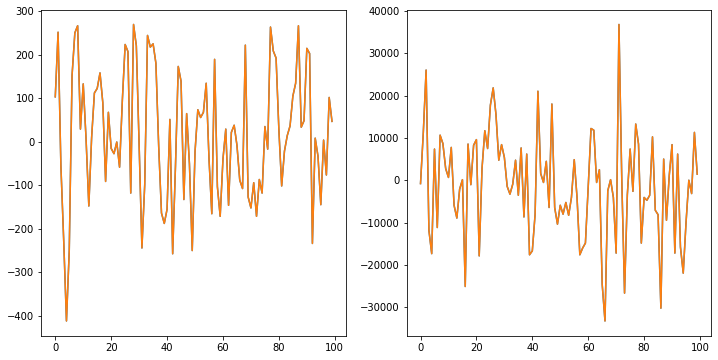

In [78]:
plt.figure(figsize=(12, 6))
plt.subplot(121)

plt.plot(io_array_tr[81,:100])
plt.plot(L1102_fa[:100])

plt.subplot(122)
plt.plot(io_array_tr[69,:100])
plt.plot(L0906_fa[:100])

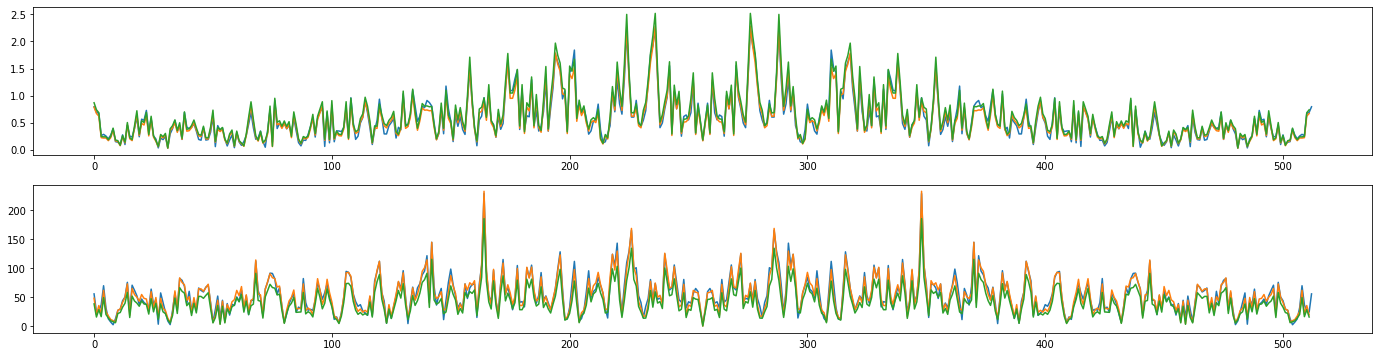

In [451]:
plt.figure(figsize=(24, 6))

plt.subplot(211)
plt.plot(np.abs(L1102_ft.mean(axis=0)))
plt.plot(np.abs(fft_data[c1.idx(), :, :].mean(axis=1)) * 0.5)
plt.plot(np.abs(io_array_ft[c1.idx(), :, :].mean(axis=1) * 512 * 16))

plt.subplot(212)
plt.plot(np.abs(L0906_ft.mean(axis=0)))
plt.plot(np.abs(fft_data[c2.idx(), :, :].mean(axis=1)) * 0.5)
plt.plot(np.abs(io_array_ft[c2.idx(), :, :].mean(axis=1) * 512 * 16 * 64))

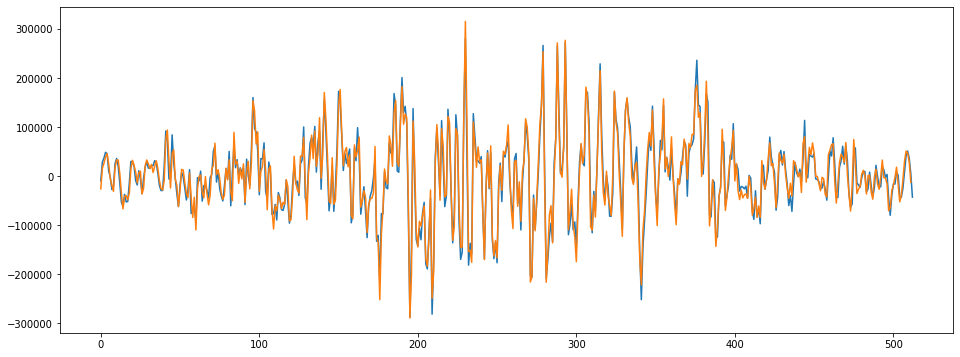

In [457]:
plt.figure(figsize=(16, 6))
plt.plot(A.Dlist[1].val[0] * 4)
plt.plot(ralphs_task[1,:])

In [448]:
def corr_here_v1(X, Y, wf, nfft):    
    res = np.zeros(X.shape)
    
    for b in range(X.shape[1]):
        XX = X[:, b]
        YY = Y[:, b]
        _tmp = np.fft.ifftshift(XX * YY.conj() / wf)
        _tmp = np.fft.ifft(_tmp, n=nfft) * nfft
        res[:, b] = np.fft.fftshift(_tmp)    
    return(res)

def corr_here_v2(X, Y, wf, nfft):
    _tmp = np.fft.ifftshift(X * Y.conj(), axes=0) / wf
    _tmp = np.fft.ifft(_tmp, n=nfft, axis=0) * nfft
    _tmp = np.fft.fftshift(_tmp, axes=0)

    res = _tmp.mean(axis=1).real
    
    return(res)

def corr_here_v3(X, Y, wf, nfft):
    print(X.shape, Y.shape)
    res = np.zeros(X.shape)
    for b in range(X.shape[0]):
        XX = X[b, :]
        YY = Y[b, :]
        _tmp = np.fft.ifftshift(XX * YY.conj() / wf)
        _tmp = np.fft.ifft(_tmp, n=nfft) * nfft
        res[b, :] = np.fft.fftshift(_tmp)    
    return(res)

In [449]:
mycorr1_1 = corr_here_v1(io_array_ft[c1.idx(), :, :], io_array_ft[c2.idx(), :, :], win_factor, 512)
mycorr1_2 = corr_here_v1(fft_data[c1.idx(), :, :], fft_data[c2.idx(), :, :], win_factor, 512)
mycorr1_3 = corr_here_v1(A.Dlist[0].spdata[0,:,:].T, A.Dlist[1].spdata[0,:,:].T, win_factor, 513)

/global/homes/r/rkube/.conda/envs/xgc-adios2-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


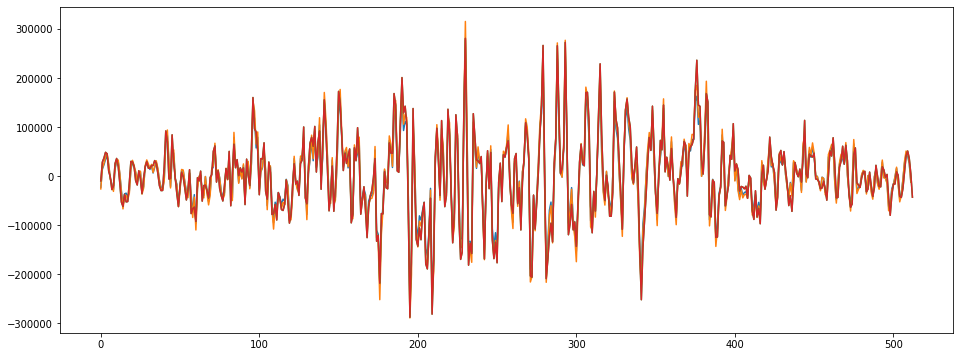

In [450]:
plt.figure(figsize=(16, 6))
plt.plot(mycorr1_1.mean(axis=1) * -1 * 512 * 512 * 512 * 128)
plt.plot(mycorr1_2.mean(axis=1))
plt.plot(mycorr1_3.mean(axis=1) * 4)

plt.plot(A.Dlist[1].val[0] * 4)

In [366]:
mycorr2_1 = corr_here_v2(io_array_ft[c1.idx(), :, :], io_array_ft[c2.idx(), :, :], win_factor, 512)
mycorr2_2 = corr_here_v2(fft_data[c1.idx(), :, :], fft_data[c2.idx(), :, :], win_factor, 512)
mycorr2_3 = corr_here_v2(A.Dlist[0].spdata[0,:,:].T, A.Dlist[1].spdata[0,:,:].T, win_factor, 513)

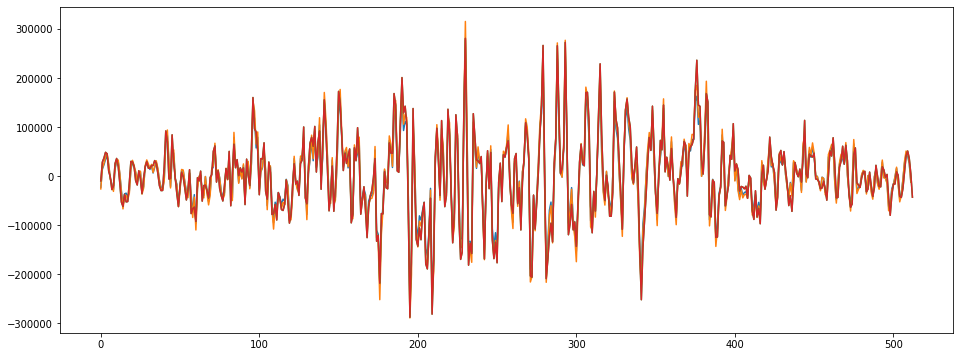

In [410]:
plt.figure(figsize=(16, 6))
plt.plot(mycorr2_1 * 512 * 512 * 512 * 128 * -1)
plt.plot(mycorr2_2)
plt.plot(mycorr2_3 * 4)


plt.plot(A.Dlist[1].val[0] * 4)

In [390]:
mycorr3_1 = corr_here_v3(io_array_ft[c1.idx(), :, :].T, io_array_ft[c2.idx(), :, :].T, win_factor, 512)
mycorr3_2 = corr_here_v3(fft_data[c1.idx(), :, :].T, fft_data[c2.idx(), :, :].T, win_factor, 512)
mycorr3_3 = corr_here_v3(A.Dlist[0].spdata[0,:,:], A.Dlist[1].spdata[0,:,:], win_factor, 513)

(38, 512) (38, 512)
(38, 512) (38, 512)
(37, 513) (37, 513)


/global/homes/r/rkube/.conda/envs/xgc-adios2-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


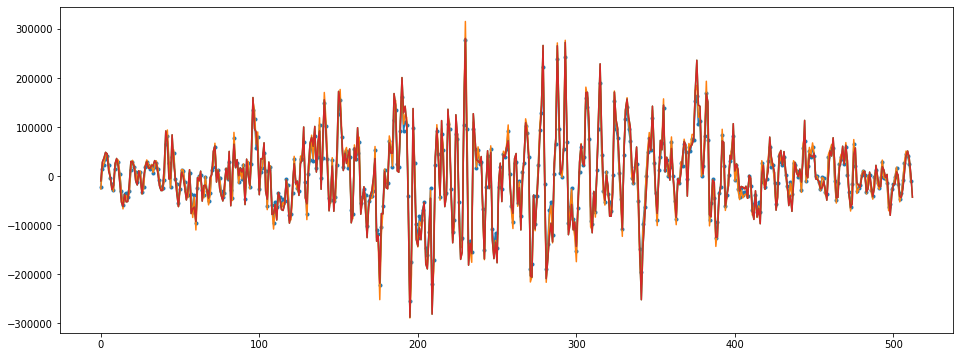

In [395]:
plt.figure(figsize=(16, 6))

plt.plot(mycorr3_1.mean(axis=0) * 512 * 512 * 512 * 128 * -1, '.-')
plt.plot(mycorr3_2.mean(axis=0))
plt.plot(mycorr3_3.mean(axis=0) * 4)

plt.plot(A.Dlist[1].val[0] * 4)

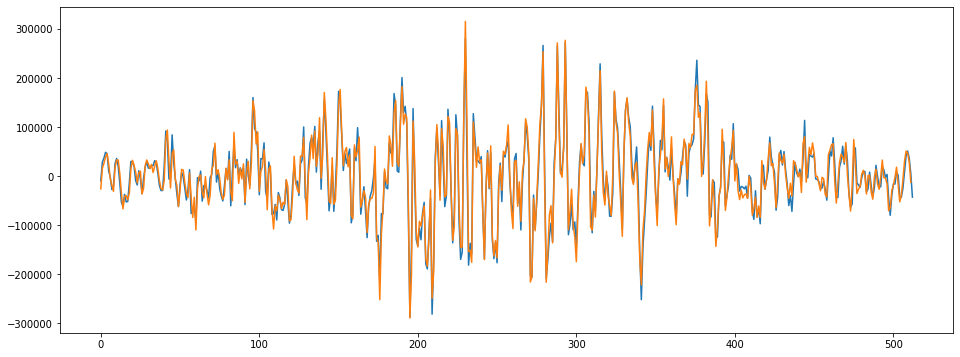

In [454]:
plt.figure(figsize=(16, 6))
plt.plot(A.Dlist[1].val[0] * 4)
plt.plot(ralphs_task[1,:])

In [455]:
?np.fft.fftshift

Signature: np.fft.fftshift(x, axes=None)
Docstring:
Shift the zero-frequency component to the center of the spectrum.

This function swaps half-spaces for all axes listed (defaults to all).
Note that ``y[0]`` is the Nyquist component only if ``len(x)`` is even.

Parameters
----------
x : array_like
    Input array.
axes : int or shape tuple, optional
    Axes over which to shift.  Default is None, which shifts all axes.

Returns
-------
y : ndarray
    The shifted array.

See Also
--------
ifftshift : The inverse of `fftshift`.

Examples
--------
>>> freqs = np.fft.fftfreq(10, 0.1)
>>> freqs
array([ 0.,  1.,  2.,  3.,  4., -5., -4., -3., -2., -1.])
>>> np.fft.fftshift(freqs)
array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

Shift the zero-frequency component only along the second axis:

>>> freqs = np.fft.fftfreq(9, d=1./9).reshape(3, 3)
>>> freqs
array([[ 0.,  1.,  2.],
       [ 3.,  4., -4.],
       [-3., -2., -1.]])
>>> np.fft.fftshift(freqs, axes=(1,))
array([[ 2.,  0.,  1

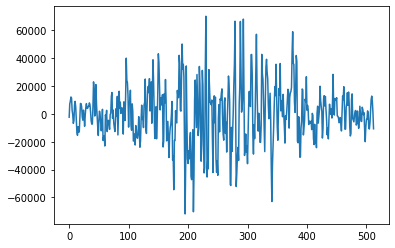

In [440]:
plt.plot(A.Dlist[1].val[0])

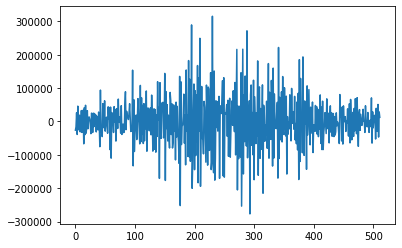

In [444]:
plt.plot(ralphs_task[1,:])

In [446]:
fft_data[81, :3, :3]

array([[-4.52595453+0.j        ,  3.02176731+0.j        ,
        -1.03710544+0.j        ],
       [ 2.00627465+0.04752319j, -2.87365604+1.25956784j,
         0.45997965+0.06533607j],
       [ 1.74696946+1.66070195j,  1.43147038+0.68556837j,
        -2.25369864-4.82010147j]])

In [445]:
fft_data[69, :3, :3]

array([[  24.03638611  +0.j        ,   10.91992311  +0.j        ,
        -454.54736316  +0.j        ],
       [-167.89281023+493.44593839j,   17.60789618+140.09565643j,
         411.48814714-264.11630569j],
       [ 244.7375125 -773.97546759j,  118.9707723 -211.90353321j,
           4.74500084+366.62619547j]])

In [ ]:
[[  0.20389791 +0.j          11.67620436 +0.j
  -19.01072347 +0.j        ]
 [  4.08450249 -4.36894793j -12.79742686 +5.90113653j
   15.53269861 +4.14498197j]
 [ -9.76455566 -7.68016206j  11.64976585-16.74563499j
   -0.27751791 -4.48495226j]]

In [13]:
fname = "/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/018431/KSTAR_018431_f32.bp"

ECEI_L1102 = []
ECEI_L0906 = []

with adios2.open(fname, "r") as fh:
    for fstep in fh:
        # print variables information
        step_vars = fstep.available_variables()
        
        if fh.current_step() > 5:
            break
        
        
        ECEI_L1102.append(fstep.read("ECEI_L1102"))
        ECEI_L0906.append(fstep.read("ECEI_L0906"))
 
ECEI_L1102 = np.array(ECEI_L1102)
ECEI_L0906 = np.array(ECEI_L0906)

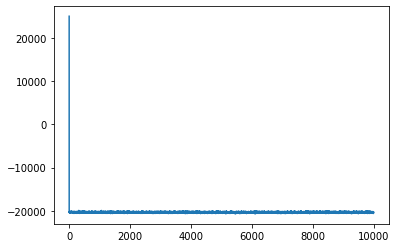

In [33]:
plt.plot(ECEI_L1102[0,:])